https://www.youtube.com/watch?v=woKYyhLCcnU

In [72]:
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy as db
from sqlalchemy.orm import Session
import matplotlib as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

%matplotlib inline

#### Creating sqlite database
    follow directions from [here](http://stat-computing.org/dataexpo/2009/sqlite.html) for sqlite database setup

In [73]:
engine = db.create_engine('sqlite:///flights.sqlite3', echo=True)     #relative directory (in same folder as this notebook so no directory)
connection = engine.connect()
flights = db.Table('ontime', db.MetaData(), autoload=True, autoload_with=engine)
session = Session(bind=engine)


2020-03-21 13:21:21,638 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-03-21 13:21:21,654 INFO sqlalchemy.engine.base.Engine ()
2020-03-21 13:21:21,656 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-03-21 13:21:21,657 INFO sqlalchemy.engine.base.Engine ()
2020-03-21 13:21:21,695 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("ontime")
2020-03-21 13:21:21,696 INFO sqlalchemy.engine.base.Engine ()
2020-03-21 13:21:21,701 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("ontime")
2020-03-21 13:21:21,703 INFO sqlalchemy.engine.base.Engine ()


NoSuchTableError: ontime

In [74]:
cols = flights.columns.keys()

In [75]:
#q = session.query(flights)
#q2 = q.filter(flights.columns.Year.cast(db.Integer) == 2008)
#%%time
#list08 = q2.all()

In [76]:
%%time
first = list(session.query(flights).limit(7009728))
#7009728

2020-03-21 13:21:22,714 INFO sqlalchemy.engine.base.Engine SELECT ontime."Year" AS "ontime_Year", ontime."Month" AS "ontime_Month", ontime."DayofMonth" AS "ontime_DayofMonth", ontime."DayOfWeek" AS "ontime_DayOfWeek", ontime."DepTime" AS "ontime_DepTime", ontime."CRSDepTime" AS "ontime_CRSDepTime", ontime."ArrTime" AS "ontime_ArrTime", ontime."CRSArrTime" AS "ontime_CRSArrTime", ontime."UniqueCarrier" AS "ontime_UniqueCarrier", ontime."FlightNum" AS "ontime_FlightNum", ontime."TailNum" AS "ontime_TailNum", ontime."ActualElapsedTime" AS "ontime_ActualElapsedTime", ontime."CRSElapsedTime" AS "ontime_CRSElapsedTime", ontime."AirTime" AS "ontime_AirTime", ontime."ArrDelay" AS "ontime_ArrDelay", ontime."DepDelay" AS "ontime_DepDelay", ontime."Origin" AS "ontime_Origin", ontime."Dest" AS "ontime_Dest", ontime."Distance" AS "ontime_Distance", ontime."TaxiIn" AS "ontime_TaxiIn", ontime."TaxiOut" AS "ontime_TaxiOut", ontime."Cancelled" AS "ontime_Cancelled", ontime."CancellationCode" AS "ontime

In [77]:
df = pd.DataFrame(data = first, columns = cols)

In [78]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,...,4,8,0,,0,NA,NA,NA,NA,NA
1,2008,1,3,4,754,735,1002,1000,WN,3231,...,5,10,0,,0,NA,NA,NA,NA,NA
2,2008,1,3,4,628,620,804,750,WN,448,...,3,17,0,,0,NA,NA,NA,NA,NA
3,2008,1,3,4,926,930,1054,1100,WN,1746,...,3,7,0,,0,NA,NA,NA,NA,NA
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,...,3,10,0,,0,2,0,0,0,32


# Flights in 2008

In [79]:
df08 = df[df.Year==2008]

In [80]:
len(df08)

7009728

In [81]:
df08 = df08.sample(frac = .20, random_state = 2)

In [82]:
len(df08)

1401946

### Preprocessing

In [83]:
#filter out Canceled flights
df08 = df08[df08.Cancelled != 1]

In [84]:
#need an arrival time for all the flights
df08 = df08[df08.ArrDelay != "NA"]

In [85]:
#drop 'CancellationCode','Diverted'
df08 = df08.drop(columns =['CancellationCode','Diverted', "Cancelled"])

In [86]:
#turning columns to ints
df08['ArrDelay'] = df08['ArrDelay'].astype(int)
df08['ArrTime'] = df08['ArrTime'].astype(int)
df08['AirTime'] = df08['AirTime'].astype(int)
df08['DepTime'] = df08['DepTime'].astype(int)
df08['ActualElapsedTime'] = df08['ActualElapsedTime'].astype(int)
df08['CRSElapsedTime'] = df08['CRSElapsedTime'].astype(int)
df08['DepDelay'] = df08['DepDelay'].astype(int)
df08['TaxiIn'] = df08['TaxiIn'].astype(int)
df08['TaxiOut'] = df08['TaxiOut'].astype(int)

In [87]:
#changing NAs to 0 for types of delays
df08.loc[df08.CarrierDelay =="NA", "CarrierDelay"]=0
df08.loc[df08.WeatherDelay =="NA", "WeatherDelay"]=0
df08.loc[df08.NASDelay=="NA","NASDelay"]=0
df08.loc[df08.SecurityDelay=="NA","SecurityDelay"]=0
df08.loc[df08.LateAircraftDelay =="NA","LateAircraftDelay"]=0

In [88]:
# Categorical boolean mask
categorical_feature_mask = df08.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08.columns[categorical_feature_mask].tolist()

In [89]:
len(df08)

1371008

In [90]:
df08 = df08.drop(columns="TailNum")

In [91]:
#all flights are from 2008 so shouldn't make a difference
df08 = df08.drop(columns = 'Year')

In [92]:
#might not be easy for someone to quickly find the distance in miles for their flight
df08 = df08.drop(columns = "Distance")

In [93]:
#might not have same flight number is 2020 as in 2008
df08 = df08.drop(columns = "FlightNum")

In [94]:
#would need to onehot encode, its possible but would take awhile 
#think about adding this once app is functional
df08 = df08.drop(columns = ['UniqueCarrier', 'Origin', 'Dest'])

In [95]:
df08.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3163108,6,27,5,1953,2000,2100,2105,67,65,52,-5,-7,5,10,0,0,0,0,0
4161727,7,27,7,1042,1036,1112,1100,30,24,17,12,6,2,11,0,0,0,0,0
1603857,3,27,4,1449,1454,1945,1957,176,183,153,-12,-5,14,9,0,0,0,0,0
565337,1,1,2,2150,2115,2307,2251,197,216,177,16,35,4,16,16,0,0,0,0
4612539,8,29,5,1514,1513,1647,1702,93,109,77,-15,1,7,9,0,0,0,0,0


In [96]:
df08_test = df08

## Feature Engineering

##### Classifier of delay columnns

In [97]:
#adding delayed column for over delays over 60min
df08_test['delayedOverHour'] = 0
df08_test.loc[df08['ArrDelay'] > 60,'delayedOverHour'] = 1

In [98]:
#adding delayed column for over delays over 30min
df08_test['delayedOver30'] = 0
df08_test.loc[df08['ArrDelay'] > 30,'delayedOver30'] = 1

In [99]:
df08_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,...,DepDelay,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delayedOverHour,delayedOver30
3163108,6,27,5,1953,2000,2100,2105,67,65,52,...,-7,5,10,0,0,0,0,0,0,0
4161727,7,27,7,1042,1036,1112,1100,30,24,17,...,6,2,11,0,0,0,0,0,0,0
1603857,3,27,4,1449,1454,1945,1957,176,183,153,...,-5,14,9,0,0,0,0,0,0,0
565337,1,1,2,2150,2115,2307,2251,197,216,177,...,35,4,16,16,0,0,0,0,0,0
4612539,8,29,5,1514,1513,1647,1702,93,109,77,...,1,7,9,0,0,0,0,0,0,0


## Predicting whether you will be delayed
average layover is an hour

In [100]:
feature_cols = list(df08_test.columns)
#feature_cols

In [101]:
feature_cols

['Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'TaxiIn',
 'TaxiOut',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'delayedOverHour',
 'delayedOver30']

In [102]:
categorical_feature_mask = df08_test.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08_test.columns[categorical_feature_mask].tolist()
#list(categorical_feature_mask)

In [103]:
foresight_cols = ["ArrTime","ActualElapsedTime","DepDelay",'delayedOver30', 'delayedOverHour',"AirTime","ArrDelay", "DepTime","TaxiIn","TaxiOut",'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay"]
## 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay",
cols_drop = foresight_cols
for i in cols_drop:
    feature_cols.remove(i)
X = df08_test[feature_cols] # Features
y = df08_test.delayedOverHour # Target variable

In [104]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 6) (1096806,)
(274202, 6) (274202,)


###### Random Forest
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [105]:
X = df08_test[feature_cols] # Features
y = df08_test.delayedOverHour # Target variable

In [106]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 6) (1096806,)
(274202, 6) (274202,)


In [107]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
model = rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 0.9267729629980817


In [108]:
X_test.head()
#type(X_test)

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime
7000034,12,5,5,1628,1806,98
2803138,5,29,4,1235,1350,75
3634110,7,11,5,1120,1240,80
2454099,5,22,4,1135,1255,80
5805594,10,4,6,1410,1555,105


In [109]:
print(len(predictions))
print(sum(predictions))

#percent flights model predicted were late
sum(predictions)/len(predictions)

274202
3157


0.011513409821956077

In [110]:
#percent of real late flights
sum(y_test)/len(predictions)

0.0668922910846748

In [111]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [112]:
#True positives, false positives, true negatives, false negatives 
perf_measure(predictions, list(y_test))

(710, 17632, 253413, 2447)

In [113]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: CRSArrTime           Importance: 0.28
Variable: CRSElapsedTime       Importance: 0.26
Variable: CRSDepTime           Importance: 0.25
Variable: DayofMonth           Importance: 0.11
Variable: Month                Importance: 0.05
Variable: DayOfWeek            Importance: 0.05


#### Save model

In [114]:
import pickle
model_file_path = '/Users/alderik/Documents/Job/Projects/FlightDelayApp/'
with open('mlp_rf.pkl', 'wb') as handle:
    pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)

# -------------------------------------------------------------------------------------------

In [ ]:
# #Having trouble graphing a tree with all the one-hot encoded cat-features

# # Extract single tree
# estimator = model.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='delays.dot', 
#                 feature_names = feature_cols,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'delays.dot', '-o', 'delay.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'delay.png')

###### Cross Validation with KFolds of RF

In [87]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt

X.to_numpy() # create an array
# Create another array
kf = KFold(n_splits=10) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=10, random_state=None, shuffle=False)


In [88]:
import time

losses = []
models = []
test_scores = []
train_scores = []
numfold = []
num=0
s_time = time.time()

for k in range(2): #make bigger than 2 to make larger ensemble
    #preventing overfitting with Kfold
    kfold = KFold(10, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
        print("-----------")
        print("-----------")
        tr_x,tr_y = X.iloc[tr_inds],y.iloc[tr_inds]
        val_x,val_y = X.iloc[val_inds],y.iloc[val_inds]
        rf = RandomForestClassifier(n_estimators = 5, random_state = 42)
        model = rf.fit(tr_x,tr_y)
        predictions = rf.predict(X_test)
        models.append(model)
        test_scores.append(model.score(X_test, y_test))
        train_scores.append(model.score(X_train, y_train))
        num+=1
        numfold.append(num)
        print("the %d fold score is %f"%((k_fold+1),model.score(X_test, y_test)))

-----------
-----------
the 1 fold score is 0.972648
-----------
-----------
the 2 fold score is 0.973410
-----------
-----------
the 3 fold score is 0.973206
-----------
-----------
the 4 fold score is 0.973417
-----------
-----------
the 5 fold score is 0.973323
-----------
-----------
the 1 fold score is 0.972768
-----------
-----------
the 2 fold score is 0.972994
-----------
-----------
the 3 fold score is 0.972495
-----------
-----------
the 4 fold score is 0.972786
-----------
-----------
the 5 fold score is 0.973195


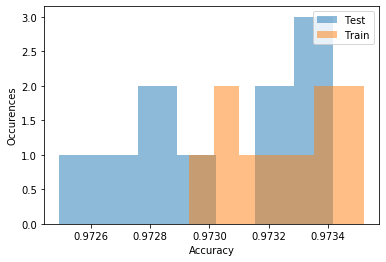

In [91]:
from matplotlib import pyplot

x = test_scores
y = train_scores

bins = 7

pyplot.hist(x, bins, alpha=0.5, label='Test')
pyplot.hist(y, bins, alpha=0.5, label='Train')
pyplot.legend(loc='upper right')
pyplot.ylabel("Occurences")
pyplot.xlabel("Accuracy")
pyplot.show()

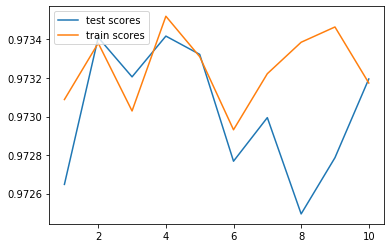

In [90]:
plt.plot(numfold, test_scores)
plt.plot(numfold, train_scores)

plt.legend(['test scores', 'train scores'], loc='upper left')

plt.show()

In [ ]:
# #output of decision tree
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('airlinedelays.png')
# Image(graph.create_png())

## Predicting Amount of Time Delayed

In [115]:
feature_cols = list(df08_test.columns)
#feature_cols

In [116]:
categorical_feature_mask = df08_test.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08_test.columns[categorical_feature_mask].tolist()
#list(categorical_feature_mask)

In [117]:
foresight_cols = ["ArrTime","ActualElapsedTime","DepDelay",'delayedOver30', 'delayedOverHour',"AirTime","ArrDelay","DepTime","TaxiIn","TaxiOut"]
#'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay", 
cols_drop = foresight_cols
for i in cols_drop:
    feature_cols.remove(i)
X = df08_test[feature_cols] # Features
y = df08_test.ArrDelay # Target variable

In [118]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 336) (1096806,)
(274202, 336) (274202,)


In [119]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
model = rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 0.43041202768938147


In [120]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NASDelay             Importance: 0.24
Variable: LateAircraftDelay    Importance: 0.13
Variable: CarrierDelay         Importance: 0.09
Variable: DayofMonth           Importance: 0.07
Variable: CRSArrTime           Importance: 0.05
Variable: FlightNum            Importance: 0.05
Variable: Month                Importance: 0.04
Variable: DayOfWeek            Importance: 0.04
Variable: CRSDepTime           Importance: 0.04
Variable: CRSElapsedTime       Importance: 0.04
Variable: Distance             Importance: 0.02
Variable: WeatherDelay         Importance: 0.01
Variable: _ORD                 Importance: 0.01
Variable: Year                 Importance: 0.0
Variable: SecurityDelay        Importance: 0.0
Variable: _ABE                 Importance: 0.0
Variable: _ABI                 Importance: 0.0
Variable: _ABQ                 Importance: 0.0
Variable: _ABY                 Importance: 0.0
Variable: _ACK                 Importance: 0.0
Variable: _ACT                 Importance: 0.0


In [121]:
feature_cols = list(df08_test.columns)
#feature_cols

In [122]:
categorical_feature_mask = df08_test.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08_test.columns[categorical_feature_mask].tolist()
#list(categorical_feature_mask)

In [123]:
foresight_cols = ["ArrTime","ActualElapsedTime","DepDelay",'delayedOver30', 'delayedOverHour',"AirTime","ArrDelay","TaxiIn","TaxiOut"]
#'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay", "DepTime",
cols_drop = foresight_cols
for i in cols_drop:
    feature_cols.remove(i)
X = df08_test[feature_cols] # Features
y = df08_test.ArrDelay # Target variable

In [124]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 337) (1096806,)
(274202, 337) (274202,)


In [125]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
model = rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 0.8949579723215618


In [126]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: CRSDepTime           Importance: 0.26
Variable: NASDelay             Importance: 0.24
Variable: DepTime              Importance: 0.21
Variable: LateAircraftDelay    Importance: 0.12
Variable: CarrierDelay         Importance: 0.08
Variable: CRSArrTime           Importance: 0.02
Variable: Month                Importance: 0.01
Variable: DayofMonth           Importance: 0.01
Variable: DayOfWeek            Importance: 0.01
Variable: FlightNum            Importance: 0.01
Variable: CRSElapsedTime       Importance: 0.01
Variable: Distance             Importance: 0.01
Variable: Year                 Importance: 0.0
Variable: WeatherDelay         Importance: 0.0
Variable: SecurityDelay        Importance: 0.0
Variable: _ABE                 Importance: 0.0
Variable: _ABI                 Importance: 0.0
Variable: _ABQ                 Importance: 0.0
Variable: _ABY                 Importance: 0.0
Variable: _ACK                 Importance: 0.0
Variable: _ACT                 Importance: 0.0
V